<a href="https://colab.research.google.com/github/AristovDaniil/Machine-Learning/blob/main/Lab1/Lab1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
# Устройство для вычислений: GPU, если доступен, иначе CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [ ]:
# Предобработка данных
transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация данных
])

In [ ]:
# Загрузка данных CIFAR-10
batch_size = 128

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 30.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


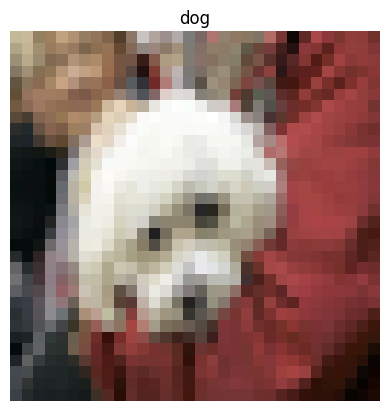

In [ ]:
# Визуализация одного изображения из тренировочного набора
classes = train_dataset.classes
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Вывод одного изображения
plt.imshow(images[0].permute(1, 2, 0) * 0.5 + 0.5)  # Отменяем нормализацию
plt.title(classes[labels[0]])
plt.axis('off')
plt.show()

In [ ]:
# Определение архитектуры модели
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)  # Свёрточный слой
        self.pool = nn.MaxPool2d(2, 2)  # Пулинг-слой
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # Второй свёрточный слой
        self.fc1 = nn.Linear(64 * 6 * 6, 64)  # Полносвязный слой
        self.fc2 = nn.Linear(64, 10)  # Выходной слой для классификации на 10 классов

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Активация ReLU после первого свёрточного слоя
        x = self.pool(F.relu(self.conv2(x)))  # Активация ReLU после второго свёрточного слоя
        x = torch.flatten(x, 1)  # Преобразование в плоский вектор
        x = F.relu(self.fc1(x))  # Активация ReLU после полносвязного слоя
        x = self.fc2(x)  # Выходной слой (без активации, используется позже)
        return x

# Создание экземпляра модели
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()  # Функция потерь для классификации
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор Adam
# Обучение модели
num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    model.train()  # Установить модель в режим обучения
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход, функция потерь и обратное распространение
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Эпоха {epoch+1}, Потери: {running_loss / len(train_loader)}")

Эпоха 1, Потери: 1.5141453349681766
Эпоха 2, Потери: 1.176688617757519
Эпоха 3, Потери: 1.0222112887045915
Эпоха 4, Потери: 0.9250837771788888
Эпоха 5, Потери: 0.8518450754072965
Эпоха 6, Потери: 0.7946405857420333
Эпоха 7, Потери: 0.7399147774862207
Эпоха 8, Потери: 0.6971360740759184
Эпоха 9, Потери: 0.6487428220489141
Эпоха 10, Потери: 0.6080104047075257


In [ ]:
# Оценка модели
model.eval()  # Установить модель в режим оценки
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Предсказанный класс
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Точность на тестовом наборе: {100 * correct / total:.2f}%")

Точность на тестовом наборе: 70.99%
